**Digital Signal and Image Management <br/>
Master's Degree in Data Science (A.Y. 2023/2024)**<br/>
**University of Milano - Bicocca**<br/>

Induni Sandapiumi Nawarathna Pitiyage - matr. 906451<br/>
Yuliia Tsymbal, matr. 894213<br/>
Sara Campolattano - matr. 906453

## **Bi-dimensional signal processing: Video Classiication**

**Outline :**
* We chose to perform on video classification.
* For this, we found a dataset UCF101,<br/>
https://www.kaggle.com/datasets/matthewjansen/ucf101-action-recognition.<br/>The
dataset contains 101 different human action classes, such as "playing guitar",
"surfing", and "knitting". It includes 13,320 video clips (collected from YouTube), and
each video clip is labeled with a single action class.<br/>
* The model architecture consists of a recurrent neural network (RNN).




In [7]:
!PYTHONHASHSEED=0

In [8]:
# Importing Libraries
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
import zipfile
from shutil import copyfile
import seaborn as sns

import imageio
from IPython.display import display, Image


import random as python_random
import tensorflow as tf
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)

* We will use a simplified version of the ucf101-action-recognition dataset.
* The procedure for sub-sampling the datset is shown here:<br/>
https://drive.google.com/file/d/1twshmsKNTDtTboI5muJLX20dVsfvttxr/view?usp=sharing
* Sub-sampled dataset can be imported to your google drive:<br/>
https://drive.google.com/file/d/1nOThIEtOwyGahZrlN62KRK-09cvg35gd/view?usp=sharing

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

from zipfile import ZipFile
file_name = "/content/drive/MyDrive/UCF101_Action_Recognition_Data.zip"
with ZipFile (file_name,'r') as zip:
  zip.extractall()
  print("Done")

Mounted at /content/drive
Done


## **Data Loading**

In [9]:
def load_video(path, max_frames=20):
    # Initialize video reader
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        # Loop through all frames
        while True:

            # Capture frame
            ret, frame = cap.read()
            if not ret:
                break

            # Resize frame to fixed size
            frame = cv2.resize(frame, (224,224))

            # Convert BGR to RGB
            frame = frame[:, :, [2, 1, 0]]

            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [10]:
# Load a sample video
cur_vid = load_video('/content/train/v_BenchPress_g01_c01.avi')

# Shape of the data structure
cur_vid.shape

(20, 224, 224, 3)

* The video is structured as 4D tensor.
* Single video contains 20 frames where each frame is a color image of size 224x224 pixels with 3 color channels.

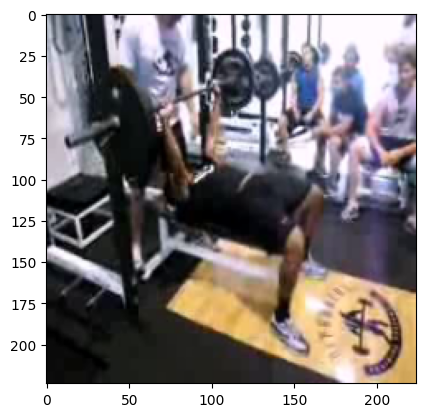

In [11]:
# Visualization of the first frame
plt.imshow(cur_vid[0])
plt.grid(False)
plt.show()

## **Feature Extraction**

In [12]:
# Load a pretrained neural network
net = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='max')

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
# Define a neural feature extractor
def neural_features(cur_vid):
    # Perform the same pre-processing operations that were used for the training of MobileNet
    cur_vid_prep = keras.applications.mobilenet_v2.preprocess_input(cur_vid)
    # Run pretrained MobileNet
    cur_vid_feats = net.predict(cur_vid_prep, verbose='false')
    return cur_vid_feats

In [14]:
# Test the feature extractor on our sample video
cur_vid_feats = neural_features(cur_vid)

In [16]:
# Load the list of training images
df_train = pd.read_csv('train.csv')
# Load the list of test images
df_test = pd.read_csv('test.csv')

print(f"Total videos for training: {len(df_train)}")
print(f"Total videos for testing: {len(df_test)}")

Total videos for training: 600
Total videos for testing: 202


In [17]:
df_train.sample(10)

,clip_name,label
434,v_PlayingGuitar_g21_c06.avi,PlayingGuitar
122,v_ShavingBeard_g07_c04.avi,ShavingBeard
224,v_ShavingBeard_g19_c04.avi,ShavingBeard
479,v_PlayingGuitar_g13_c06.avi,PlayingGuitar
205,v_ShavingBeard_g17_c07.avi,ShavingBeard
569,v_Drumming_g15_c07.avi,Drumming
432,v_PlayingGuitar_g08_c06.avi,PlayingGuitar
526,v_Drumming_g17_c03.avi,Drumming
439,v_PlayingGuitar_g19_c05.avi,PlayingGuitar
162,v_ShavingBeard_g21_c04.avi,ShavingBeard


In [ ]:
# Number of videos in training data for video categories
category_counts = df_train['label'].value_counts()
category_counts

BenchPress       120
ShavingBeard     120
Punch            120
PlayingGuitar    120
Drumming         120
Name: label, dtype: int64

In [ ]:
# Number of videos in test data for video categories
category_counts = df_test['label'].value_counts()
category_counts

ShavingBeard     41
Drumming         41
BenchPress       40
Punch            40
PlayingGuitar    40
Name: label, dtype: int64

In [18]:
# Prepare to convert string labels into integers
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(df_train['label']))
class_vocab = label_processor.get_vocabulary()
class_vocab

['BenchPress', 'Drumming', 'PlayingGuitar', 'Punch', 'ShavingBeard']

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df['clip_name'].values.tolist()
    # Extract string labels and convert to integers
    labels = df['label'].values
    labels = label_processor(labels[..., None]).numpy()

    all_features = []
    # For each video in the list
    for idx, path in enumerate(video_paths):
        # Gather all its frames
        cur_vid = load_video(os.path.join(root_dir, path))
        # Extract features from the frames of the current video
        cur_vid_feats = neural_features(cur_vid)
        # Add to the list
        all_features.append(cur_vid_feats)

    all_features = np.array(all_features)
    return all_features, labels

In [ ]:
%%time
# Extract features from all training videos
train_data, train_labels = prepare_all_videos(df_train, 'train')
# Extract features from all test videos
test_data, test_labels = prepare_all_videos(df_test, 'test')

print(f"Frame features in train set: {train_data.shape}")
print(f"Frame features in train set: {test_data.shape}")

Frame features in train set: (600, 20, 1280)
Frame features in train set: (202, 20, 1280)
CPU times: user 1min 45s, sys: 5.7 s, total: 1min 50s
Wall time: 1min 54s


In [ ]:
# Save features
#np.save('/content/drive/MyDrive/Colab Notebooks/DSIM/Bi-dimentional_signal/train_data.npy', train_data)
#np.save('/content/drive/MyDrive/Colab Notebooks/DSIM/Bi-dimentional_signal/train_labels.npy', train_labels)
#np.save('/content/drive/MyDrive/Colab Notebooks/DSIM/Bi-dimentional_signal/test_data.npy', test_data)
#np.save('/content/drive/MyDrive/Colab Notebooks/DSIM/Bi-dimentional_signal/test_labels.npy', test_labels)

In [19]:
# Load saved features
train_data = np.load('/content/drive/MyDrive/Colab Notebooks/DSIM/Bi-dimentional_signal/train_data.npy')
train_labels = np.load('/content/drive/MyDrive/Colab Notebooks/DSIM/Bi-dimentional_signal/train_labels.npy')
test_data = np.load('/content/drive/MyDrive/Colab Notebooks/DSIM/Bi-dimentional_signal/test_data.npy')
test_labels = np.load('/content/drive/MyDrive/Colab Notebooks/DSIM/Bi-dimentional_signal/test_labels.npy')

## **Model**

In [20]:
# Define the second part of the model (v2)
frame_features_input = keras.Input((20, 1280))
x = keras.layers.GRU(32, return_sequences=True)(frame_features_input)
x = keras.layers.GRU(16, return_sequences=True)(x)
x = keras.layers.Dropout(0.2)(x)  # Adding dropout for regularization
x = keras.layers.GRU(8, return_sequences=True)(x)
x = keras.layers.GRU(4, return_sequences=False)(x)
x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)
rnn_net = keras.Model(frame_features_input, output)

In [ ]:
rnn_net.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20, 1280)]        0         
                                                                 
 gru_16 (GRU)                (None, 20, 32)            126144    
                                                                 
 gru_17 (GRU)                (None, 20, 16)            2400      
                                                                 
 dropout_4 (Dropout)         (None, 20, 16)            0         
                                                                 
 gru_18 (GRU)                (None, 20, 8)             624       
                                                                 
 gru_19 (GRU)                (None, 4)                 168       
                                                                 
 dense_12 (Dense)            (None, 16)                80  

In [21]:
# Compile model
rnn_net.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(patience=3)
# Train model
history = rnn_net.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    epochs=50,
    callbacks=[callback],
)

Epoch 1/50
19/19 [==============================] - 12s 245ms/step - loss: 1.5515 - accuracy: 0.2100 - val_loss: 1.4857 - val_accuracy: 0.2574
Epoch 2/50
19/19 [==============================] - 1s 59ms/step - loss: 1.4364 - accuracy: 0.3417 - val_loss: 1.3657 - val_accuracy: 0.5347
Epoch 3/50
19/19 [==============================] - 1s 59ms/step - loss: 1.3052 - accuracy: 0.5483 - val_loss: 1.2142 - val_accuracy: 0.6337
Epoch 4/50
19/19 [==============================] - 1s 58ms/step - loss: 1.1395 - accuracy: 0.7267 - val_loss: 1.0523 - val_accuracy: 0.7723
Epoch 5/50
19/19 [==============================] - 1s 60ms/step - loss: 0.9857 - accuracy: 0.7800 - val_loss: 0.9104 - val_accuracy: 0.7723
Epoch 6/50
19/19 [==============================] - 1s 61ms/step - loss: 0.8530 - accuracy: 0.7967 - val_loss: 0.7911 - val_accuracy: 0.7723
Epoch 7/50
19/19 [==============================] - 1s 57ms/step - loss: 0.7316 - accuracy: 0.7983 - val_loss: 0.6924 - val_accuracy: 0.7970
Epoch 8/50


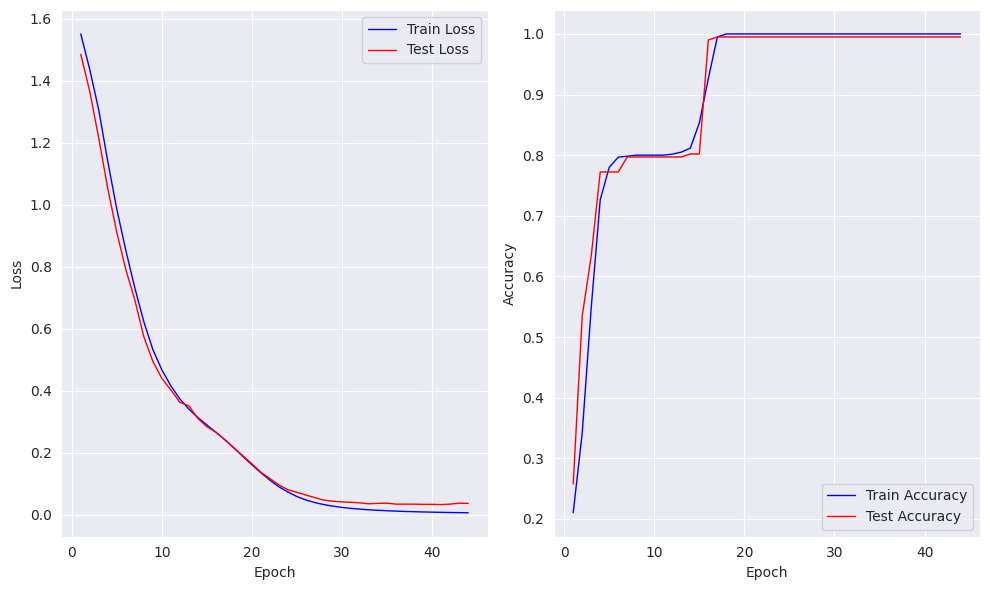

In [22]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Visualization of Loss
sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], ax=axes[0], color='blue', lw=1)
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], ax=axes[0], color='red', lw=1)
axes[0].set(xlabel='Epoch', ylabel='Loss')
# Custom Legend for Loss
legend_lines_loss = [Line2D([0], [0], color='blue', lw=1), Line2D([0], [0], color='red', lw=1)]
axes[0].legend(legend_lines_loss, ['Train Loss', 'Test Loss'])

# Visualization of Accuracy
sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], ax=axes[1], color='blue', lw=1)
sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], ax=axes[1], color='red', lw=1)
axes[1].set(xlabel='Epoch', ylabel='Accuracy')
# Custom Legend for Accuracy
legend_lines_accuracy = [Line2D([0], [0], color='blue', lw=1), Line2D([0], [0], color='red', lw=1)]
axes[1].legend(legend_lines_accuracy, ['Train Accuracy', 'Test Accuracy'])

plt.tight_layout()
plt.show()

## **Classification Model**

In [24]:
# Inference
yc_pred = rnn_net.predict(test_data)
print('Prediction shape (probability distribution):', yc_pred.shape)

# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)
print('Prediction shape (argmax):', y_pred.shape)

7/7 [==============================] - 2s 14ms/step
Prediction shape (probability distribution): (202, 5)
Prediction shape (argmax): (202,)


In [25]:
# Classification report
print('Classification report:')
print(classification_report(test_labels, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.98      1.00      0.99        41
           2       1.00      1.00      1.00        40
           3       1.00      0.97      0.99        40
           4       1.00      1.00      1.00        41

    accuracy                           1.00       202
   macro avg       1.00      0.99      1.00       202
weighted avg       1.00      1.00      1.00       202



Confusion matrix:


Text(0, 0.5, 'Ground truth class')

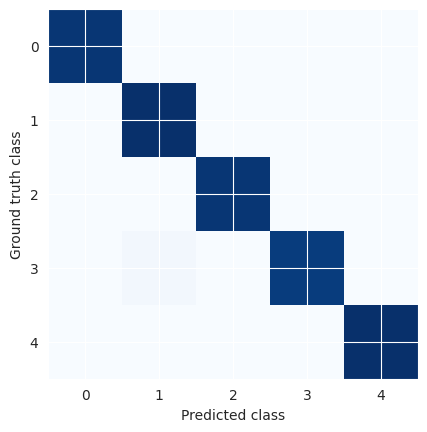

In [26]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(test_labels, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

## **Model Inference from the test data**

In [ ]:
# Load a sample video from the test set, extract neural features, and process with rnn
cur_vid = load_video('/content/test/v_Punch_g18_c03.avi', max_frames=10000)
cur_vid_feats = neural_features(cur_vid)
cur_vid_pred = rnn_net.predict(cur_vid_feats[None,...])

1/1 [==============================] - 1s 1s/step


In [ ]:
# Example usage
input_video_path = "/content/test/v_Punch_g18_c03.avi"

def convert_avi_to_gif(input_path, output_path, fps=10):

    # Set up the writer with the desired output path and frames per second
    writer = imageio.get_writer(output_path, fps=fps)

    # Read the frames from the input video file and append them to the GIF writer
    with imageio.get_reader(input_path) as reader:
        for frame in reader:
            writer.append_data(frame)

    # Close the writer to finish creating the GIF
    writer.close()

output_gif_path = "output_animation.gif"
convert_avi_to_gif(input_video_path, output_gif_path)



In [ ]:
# Display the GIF
display(Image(filename=output_gif_path))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Output probability distribution
cur_vid_pred


array([[4.3565730e-04, 5.2707719e-07, 3.3789547e-03, 9.9308455e-01,
        3.1004369e-03]], dtype=float32)

In [ ]:
# Output class name
class_vocab[cur_vid_pred.argmax()]

'Punch'

## **Model Inference on unseen data**

* Video files can be imported to your google drive:<br/>
https://drive.google.com/file/d/1F-k7eFc6hydZbr8oHQ8pwm5Lf1s0j7UE/view?usp=sharing

In [27]:
file_name = "/content/drive/MyDrive/Videos.zip"
with ZipFile (file_name,'r') as zip:
  zip.extractall()
  print("Done")

Done


**Drumming**

1/1 [==============================] - 1s 1s/step


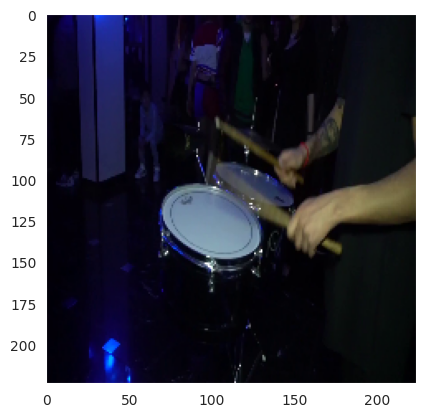

In [28]:
# Load a sample video from the test set, extract neural features, and process with rnn
cur_vid = load_video('/content/drumming.avi', max_frames=10000)
cur_vid_feats = neural_features(cur_vid)
cur_vid_pred = rnn_net.predict(cur_vid_feats[None,...])
# Visualization of the first frame
plt.imshow(cur_vid[0])
plt.grid(False)
plt.show()

In [29]:
# Output probability distribution
cur_vid_pred

array([[1.7669679e-07, 9.9168664e-01, 1.2622184e-05, 7.5966208e-03,
        7.0397300e-04]], dtype=float32)

In [30]:
# Output class name
class_vocab[cur_vid_pred.argmax()]

'Drumming'

**Playing Guitar**

1/1 [==============================] - 0s 90ms/step


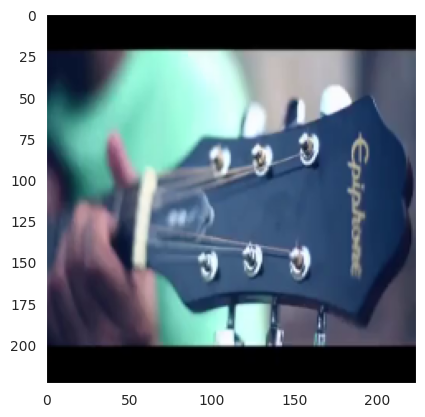

In [31]:
# Load a sample video from the test set, extract neural features, and process with rnn
cur_vid = load_video('/content/acoustic_guitar.avi', max_frames=10000)
cur_vid_feats = neural_features(cur_vid)
cur_vid_pred = rnn_net.predict(cur_vid_feats[None,...])
# Visualization of the first frame
plt.imshow(cur_vid[0])
plt.grid(False)
plt.show()

In [32]:
# Output probability distribution
cur_vid_pred

array([[3.3962766e-05, 1.2807610e-03, 9.8912501e-01, 6.0522693e-06,
        9.5542567e-03]], dtype=float32)

In [33]:
# Output class name
class_vocab[cur_vid_pred.argmax()]

'PlayingGuitar'

**Beard Shaving**

1/1 [==============================] - 0s 169ms/step


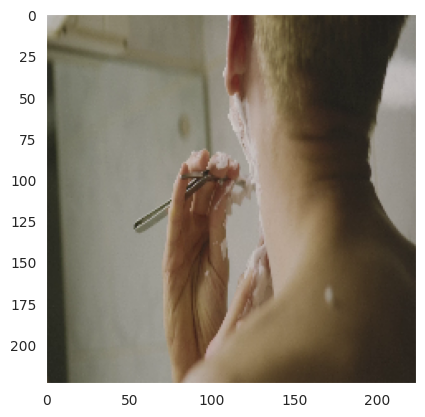

In [34]:
# Load a sample video from the test set, extract neural features, and process with rnn
cur_vid = load_video('/content/beard_shaving.avi', max_frames=10000)
cur_vid_feats = neural_features(cur_vid)
cur_vid_pred = rnn_net.predict(cur_vid_feats[None,...])
# Visualization of the first frame
plt.imshow(cur_vid[0])
plt.grid(False)
plt.show()

In [35]:
# Output probability distribution
cur_vid_pred

array([[4.1530829e-10, 3.0632576e-03, 2.4250590e-03, 1.3201114e-09,
        9.9451172e-01]], dtype=float32)

In [36]:
# Output class name
class_vocab[cur_vid_pred.argmax()]

'ShavingBeard'

**Bench press**

1/1 [==============================] - 0s 69ms/step


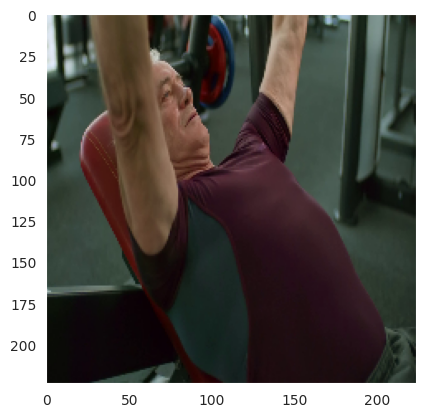

In [37]:
# Load a sample video from the test set, extract neural features, and process with rnn
cur_vid = load_video('/content/bench_press.avi', max_frames=10000)
cur_vid_feats = neural_features(cur_vid)
cur_vid_pred = rnn_net.predict(cur_vid_feats[None,...])
# Visualization of the first frame
plt.imshow(cur_vid[0])
plt.grid(False)
plt.show()

In [38]:
# Output probability distribution
cur_vid_pred

array([[0.92891985, 0.0329374 , 0.00802763, 0.02583244, 0.00428271]],
      dtype=float32)

In [39]:
# Output class name
class_vocab[cur_vid_pred.argmax()]

'BenchPress'

**Punch**

1/1 [==============================] - 0s 60ms/step


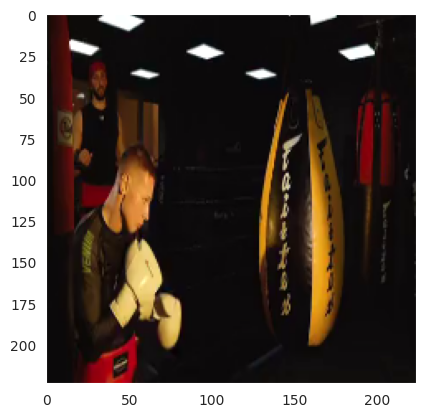

In [40]:
# Load a sample video from the test set, extract neural features, and process with rnn
cur_vid = load_video('/content/punch.avi', max_frames=10000)
cur_vid_feats = neural_features(cur_vid)
cur_vid_pred = rnn_net.predict(cur_vid_feats[None,...])
# Visualization of the first frame
plt.imshow(cur_vid[0])
plt.grid(False)
plt.show()

In [41]:
# Output probability distribution
cur_vid_pred

array([[9.97598708e-01, 8.19826673e-04, 3.95350013e-04, 1.06530171e-03,
        1.20793615e-04]], dtype=float32)

In [42]:
# Output class name
class_vocab[cur_vid_pred.argmax()]

'BenchPress'